# Determining the Distribution of Total Hours Played in a Minecraft Server Using Participant Age, Experience Level, and Subscription Status to Game-related Newsletter

**Group Participants:** Subodhee Kaluarachchi (22323646), Haiyu Long (62509666), Tyson Hutt (55249007)

# Introduction

Minecraft is a popular 3D sandbox game where the objective is to survive, collect resources, and explore the endless world made of blocks. A study conducted by a computer science research group at UBC (Smith, 2023) collected data on the Minecraft playing practices and statistics of 196 participants, including their experience level, subscription status, hashed email, total played hours, name, gender, and age *(Figure 1)*. Our analysis aims to address whether the player’s gaming experience, their subscription status to the game-related newsletter, and age are useful predictors to determine their total hours of play.

| Name of Variable |  Type  |  Meaning  |
|:----------------:|:------:|:---------:|
|  experience      |  fct   | Describes how comfortable/knowledgeable the player is with MineCraft (One of Beginner, Amateur, Regular, Pro, or Veteran)|
|  subscribe       |  lgl   | Whether they are subscribed to a game-related newsletter or not      |
|  hashedEmail     |  chr   | Their email in hashed format                                         |
|  played_hours    |  dbl   | The amount of hours they played, up to 1 decimal                     |
|  name            |  chr   | The player's first name                                              |
|  gender          |  fct   | The player's gender                                                  |
|  Age             |  int   | The player's age                                                     |

**Figure 1:** Description of the variables present in players.csv

# Methods & Results

## Data Preprocessing and Summary

First, we begin by loading in the necessary libraries that are required to perform the necessary analysis to explore and visualize our question of interest.

In [26]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

Now that we have the libraries, we can load in the **players.csv** data set with the variables in the necessary format, and remove the unwanted variables (hashedEmail and name) (*Figure 2*).

In [27]:
players_raw <- read_csv("https://raw.githubusercontent.com/ryyuerber/DSCI100_Group_26_Final_Proj/refs/heads/main/players.csv") |>
    mutate(experience = as_factor(experience)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE")) |>
    select(-hashedEmail, -name)
players_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,Age
<fct>,<fct>,<dbl>,<chr>,<dbl>
Pro,Yes,30.3,Male,9
Veteran,Yes,3.8,Male,17
Veteran,No,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Amateur,No,0.0,Prefer not to say,17
Amateur,No,2.3,Male,17
Pro,Yes,0.2,Other,NA


**Figure 2:** The data set we will be analyzing **(players.csv)**

By overview, we found that aside from the played_hours and age columns—stored as doubles—and the subscribe column—stored as a logical vector—all other columns are stored as strings. In our analysis, we focus on the **experience**, **subscribe**, and **age** metrics as potential predictors of the response variable played_hours. We aim to determine whether these indicators exhibit a sufficient correlation with the play hours to qualify as reliable predictors. Next, we will do a basic summary statistics of the dataset and identify potential problems in the dataset that may hinder our analysis.

In [28]:
players_na_sum <- colSums(is.na(players_raw))

players_na_sum

experience    subscribe played_hours       gender          Age 
           0            0            0            0            2

**Figure 3:** Determining missing values.

In [29]:
hours_played_summary <- players_raw |> summarize(played_hours_min = min(played_hours, na.rm = TRUE),
    played_hours_max = max(played_hours),
    played_hours_mean = mean(played_hours),
    played_hours_median = median(played_hours),
    played_hours_sd = sd(played_hours))

hours_played_summary

played_hours_min,played_hours_max,played_hours_mean,played_hours_median,played_hours_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,223.1,5.845918,0.1,28.35734


**Figure 4:** Summary of general statistics for **played_hours**.

In [30]:
players_zeros <- players_raw |>
    filter(played_hours == 0) |>
    summarize(count = n())

players_zeros

count
<int>
85


**Figure 5:** Determining the number of players with **zero** played hours.

In [31]:
age_summary <- players_raw |> summarize(age_min = min(Age, na.rm = TRUE),
    age_max = max(Age, na.rm = TRUE),
    age_mean = mean(Age, na.rm = TRUE),
    age_median = median(Age, na.rm = TRUE))

age_summary

age_min,age_max,age_mean,age_median
<dbl>,<dbl>,<dbl>,<dbl>
8,50,20.52062,19


**Figure 6:** Summary of general statistics for **age**.

In [32]:
ctg_summary <- players_raw |>
  select(experience, subscribe, gender) |>
  pivot_longer(cols = experience:gender, names_to = "Column", values_to = "categories") |>
  group_by(Column, categories) |>
  summarize(Count = n())

print(ctg_summary)

`summarise()` has grouped output by 'Column'. You can override using the
`.groups` argument.


# A tibble: 14 × 3
# Groups:   Column [3]
   Column     categories        Count
   <chr>      <chr>             <int>
 1 experience Amateur              63
 2 experience Beginner             35
 3 experience Pro                  14
 4 experience Regular              36
 5 experience Veteran              48
 6 gender     Agender               2
 7 gender     Female               37
 8 gender     Male                124
 9 gender     Non-binary           15
10 gender     Other                 1
11 gender     Prefer not to say    11
12 gender     Two-Spirited          6
13 subscribe  No                   52
14 subscribe  Yes                 144


**Figure 7:** Counting the number of participants that fall under each category of interest.

We started by determining if there are any missing values in any of our predictors (*Figure 3*). Analysis of play time reveals that the minimum value is 0 (*Figure 4*), indicating that some players registered an account without playing, and the summarize function shows that **85 participants** did not access the Minecraft server at all (*Figure 5*); therefore, we will employ an **alternative analysis model** that excludes these zero values. Comparing the maximum with both the mean and the median further suggests that a significant number of players engage for less than two hours—or even less than one hour (*Figure 4*). Age statistics (*Figure 6*) indicate that most players are likely young adults (15–35 years old). Regarding player proficiency (*Figure 7*), although the number of professional players is relatively small (as expected), the distribution of skilled players appears to be fairly even. Moreover, more than half of the dataset comprises contributions from male players, and most players have subscribed to the game-related newsletter (*Figure 7*). These statistics provide valuable insights for subsequent analyses, while also suggesting that our conclusions may be limited; for instance, a dataset predominantly composed of male players may imply that our findings are only applicable to that demographic.

## Prior Visualizations

In [22]:
options(repr.plot.height = 8, repr.plot.width = 6)

exp_hrs_hist <- ggplot(players_raw, aes(played_hours)) + 
    geom_histogram(binwidth = 10) + 
    geom_vline(xintercept = 0.1, linetype = "dashed") +
    facet_grid(rows = vars(experience)) +
    labs(x = "Play times (hours)",
       y = "Number of Obsevations",
       fill = "Level of Experience") +
    theme(text = element_text(size = 12))


sub_hrs_hist <- ggplot(players_raw, aes(played_hours)) + 
    geom_histogram(binwidth = 10) + 
    geom_vline(xintercept = 0.1, linetype = "dashed") +
    facet_grid(rows = vars(subscribe)) +
    labs(x = "Play times (hours)",
       y = "Number of Obsevations",
       fill = "Subscribe the game newsletter") +
    theme(text = element_text(size = 12))

age_hrs_hist <- ggplot(players_raw, aes(x = Age, y = played_hours)) + 
    geom_point() + 
    labs(x = "Age", y = "Play times (hours)",) +
    theme(text = element_text(size = 12))

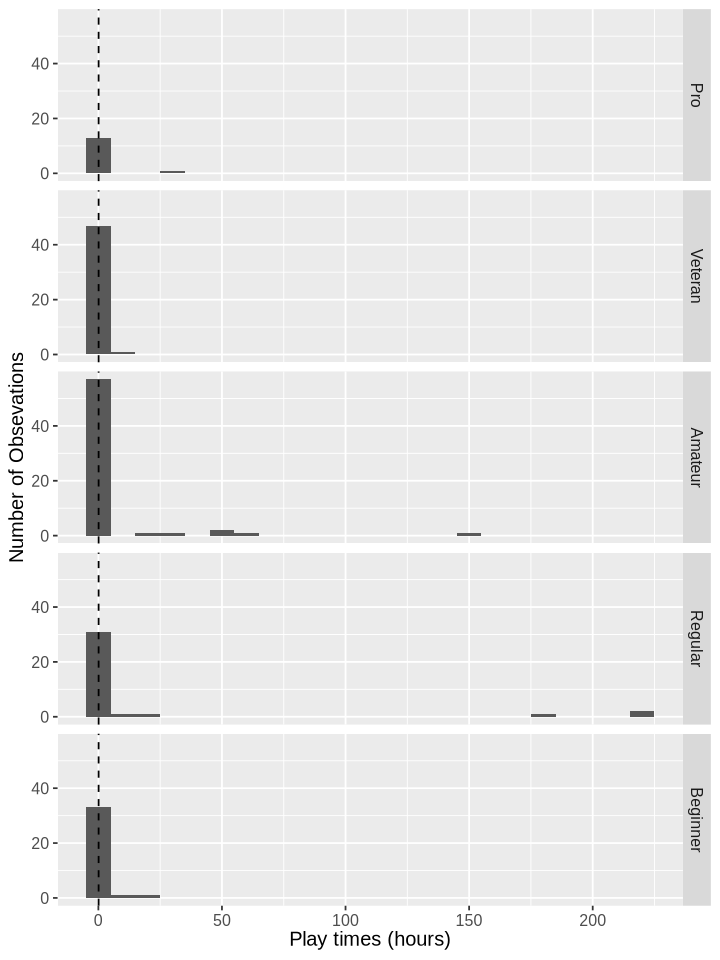

In [23]:
exp_hrs_hist

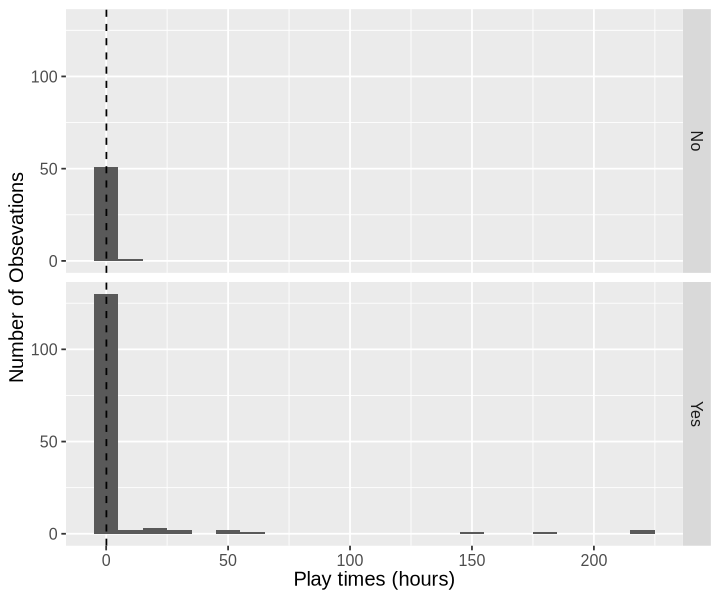

In [26]:
options(repr.plot.height = 5, repr.plot.width = 6)
sub_hrs_hist

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


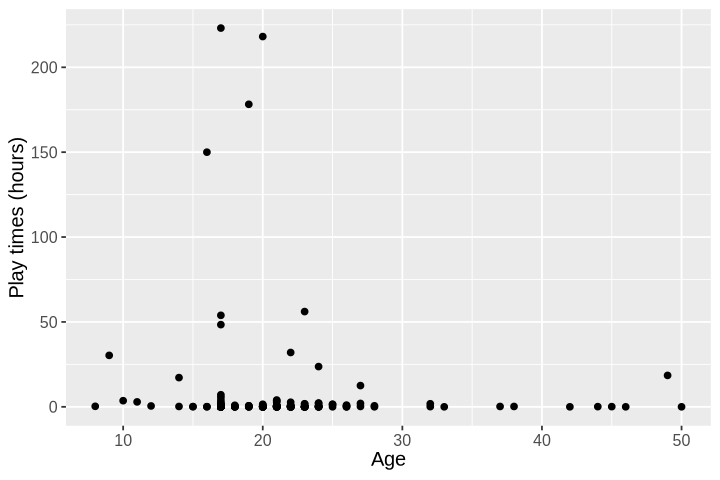

In [27]:
options(repr.plot.height = 4, repr.plot.width = 6)
age_hrs_hist

## Analysis

In [34]:
players_numericalized <- players_raw |> 
    mutate(num_subscribe = case_when(subscribe == 'Yes' ~ 1, subscribe == 'No' ~ 0)) |>
    mutate(num_experience = case_when(experience == 'Beginner' ~ 1, 
                                      experience == 'Amateur' ~ 2, 
                                      experience == 'Regular' ~ 3, 
                                      experience == 'Pro' ~ 4,
                                      experience == 'Veteran' ~ 5))

players_fn <- select(players_numericalized, Age, num_subscribe, num_experience, played_hours)

In [ ]:
players_split <- initial_split(players_fn, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

lm_spec <- linear_reg() |>
    set_engine('lm') |>
    set_mode('regression')

players_recipe <- recipe(played_hours ~ ., data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

player_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(lm_spec) |>
    fit(data = players_training)

players_pred_train <- player_fit |>
        predict(players_training) |>
        bind_cols(players_training)

lm_rmse <- metrics(players_pred_train, truth = played_hours, estimate = .pred) |>
        filter(.metric == 'rmse') |>
        select(.estimate) |>
        pull()
lm_rmse
player_fit


In [ ]:
players_fn_nonzeros <- players_fn|>
    filter(played_hours != 0)
players_fn_nonzeros

players_split_2 <- initial_split(players_fn_nonzeros, prop = 0.75, strata = played_hours)
players_training_2 <- training(players_split_2)
players_testing_2 <- testing(players_split_2)

players_recipe_2 <- recipe(played_hours ~ ., data = players_training_2) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

player_fit_2 <- workflow() |>
    add_recipe(players_recipe_2) |>
    add_model(lm_spec) |>
    fit(data = players_training_2)

players_pred_train_2 <- player_fit_2 |>
        predict(players_training_2) |>
        bind_cols(players_training_2)

lm_rmse_2 <- metrics(players_pred_train_2, truth = played_hours, estimate = .pred) |>
        filter(.metric == 'rmse') |>
        select(.estimate) |>
        pull()
lm_rmse_2
player_fit_2

# Discussion

# Reference List

Smith, Andrew. (2023, September 28). Plaicraft.ai launch. Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/2023/09/27/plaicraft/